In [1]:
# Jason Qin
# 04/26/21

# Analyzing Classification Data

Classification results from running TAPE on VDJdb TCR-antigen data.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist, hamming
import scipy.stats
import sklearn.metrics

from tape.datasets import FastaDataset, pad_sequences
from tape.tokenizers import TAPETokenizer

### Analyze Performance of Classification Model on Validation Data

In [3]:
# data_file = '/group/ag_cmb/scratch/jqin/projects/tape/results/tcr_classification_transformer_21-05-04-17-05-03_317740/eval_predictions_050521_010157.txt'
data_file = '/group/ag_cmb/scratch/jqin/projects/tape/results/tcr_classification_unique_antigens/eval_predictions_210521_031237.txt'
data = pd.read_csv(data_file, sep='\t')

In [4]:
# clean and organize data
column_names = ['input', 'target', 'prediction', 'index']
for col in column_names:
    # remove all non-numeric parts of data
    if type(data[col][0]) != str:
        continue
    data[col] = data[col].str.replace(r'.*\[', '')
    data[col] = data[col].str.replace(r'\].*', '')
    data[col] = data[col].str.replace(r'        ', ',')
    data[col] = data[col].str.strip()
    
    # convert comma-separated string of ints to list of ints
    data[col] = [np.array([float(y.strip('.')) for y in x]) for x in data[col].str.split(',')]

data = data.sort_values('index')

<ipython-input-4-8978dd737fa3>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  data[col] = data[col].str.replace(r'.*\[', '')
<ipython-input-4-8978dd737fa3>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  data[col] = data[col].str.replace(r'\].*', '')


In [5]:
inputs = data['input']
predictions = data['prediction']
targets = data['target']

# round predictions to nearest int
preds_round = np.rint(predictions)

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='prediction'>

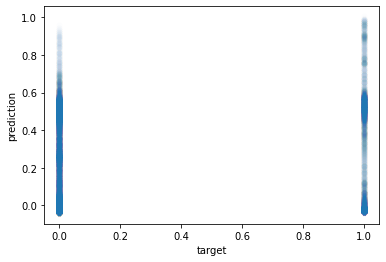

In [6]:
# how do predictions compare to targets?
sns.scatterplot(targets, predictions, alpha=0.01)

In [7]:
# calculate true positives, true negatives, false pos, and false neg
preds_confusion_matrix = sklearn.metrics.confusion_matrix(targets, preds_round)

true_neg = preds_confusion_matrix[0,0]
false_pos = preds_confusion_matrix[0,1]
false_neg = preds_confusion_matrix[1,0]
true_pos = preds_confusion_matrix[1,1]

true_neg_rate = true_neg / (true_neg + false_pos)
false_pos_rate = false_pos / (true_neg + false_pos)
false_neg_rate = false_neg / (true_pos + false_neg)
true_pos_rate = true_pos / (true_pos + false_neg)

In [8]:
print('True Negative Rate: {}'.format(true_neg_rate))
print('False Positive Rate: {}'.format(false_pos_rate))
print('False Negative Rate: {}'.format(false_neg_rate))
print('True Positive Rate: {}'.format(true_pos_rate))

True Negative Rate: 0.8380910554823598
False Positive Rate: 0.16190894451764018
False Negative Rate: 0.6326306543697848
True Positive Rate: 0.36736934563021517


### Analyze uniqueness of CDR3 and antigen sequences in training data

In [9]:
# relevant data files
data_dir = '/group/ag_cmb/scratch/jqin/projects/tape/data/tcr'
cdr3_train_file = data_dir + '/cdr3_unique_train.fasta'
antigen_train_file = data_dir + '/antigen_unique_train.fasta'
cdr3_valid_file = data_dir + '/cdr3_unique_test.fasta'
antigen_valid_file = data_dir + '/antigen_unique_test.fasta'

# set up tokenizer
tokenizer = TAPETokenizer(vocab='iupac')

# load relevant data
cdr3_train_data_uncleaned = FastaDataset(cdr3_train_file, in_memory=True)
antigen_train_data_uncleaned = FastaDataset(antigen_train_file, in_memory=True)

In [10]:
# organize data
cdr3_train_data = [tuple(tokenizer.encode(x['primary'])) for x in cdr3_train_data_uncleaned]
antigen_train_data = [tuple(tokenizer.encode(x['primary'])) for x in antigen_train_data_uncleaned]

In [11]:
# find how many times each CDR3 sequence appears in the training data
cdr3_train_counts = {}
for cdr3 in cdr3_train_data:
    if cdr3 not in cdr3_train_counts.keys():
        cdr3_train_counts[cdr3] = 1
    else:
        cdr3_train_counts[cdr3] += 1
        
# find how many times each antigen sequence appears in the training data
antigen_train_counts = {}
for antigen in antigen_train_data:
    if antigen not in antigen_train_counts.keys():
        antigen_train_counts[antigen] = 1
    else:
        antigen_train_counts[antigen] += 1

In [12]:
# find frequency of how many sequences are unique vs. duplicates
cdr3_train_unique_freq = []         # number of sequences with each copy #
cdr3_train_weighted_freq = []       # num of seq with each copy #, weighted by copy #
for key, item in cdr3_train_counts.items():
    cdr3_train_unique_freq += [item]
    cdr3_train_weighted_freq += item*[item]

antigen_train_unique_freq = []
antigen_train_weighted_freq = []
for key, item in antigen_train_counts.items():
    antigen_train_unique_freq += [item]
    antigen_train_weighted_freq += item*[item]

In [13]:
# table of CDR3 sequence frequency in training data
pd.value_counts(cdr3_train_unique_freq).to_frame().sort_index().transpose()

,1,2,3,4,5,6,7,8,9,10,...,99,103,106,123,140,144,145,154,155,344
0,46497,4879,1126,504,256,117,86,60,54,34,...,1,1,1,1,1,1,1,1,1,1


<AxesSubplot:ylabel='Density'>

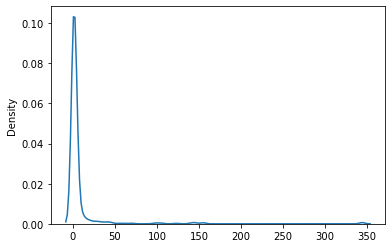

In [14]:
# density plot of CDR3 sequence frequency in training data
# density is weighted by how much each sequence appears in training data
sns.kdeplot(cdr3_train_weighted_freq)

In [15]:
# table of antigen sequence frequency in training data
pd.value_counts(antigen_train_unique_freq).to_frame().sort_index().transpose()

,1,2,3,4,5,6,7,8,9,10,...,859,874,1486,1639,2671,2722,3544,7051,9580,27944
0,5,41,3,11,1,3,2,2,1,3,...,1,1,1,1,1,1,1,1,1,1


<AxesSubplot:ylabel='Density'>

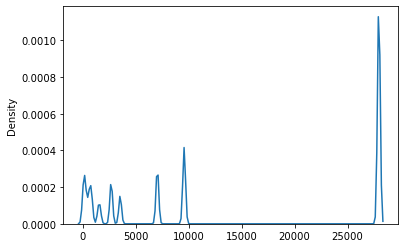

In [16]:
# density plot of CDR3 sequence frequency in training data
# density is weighted by how much each sequence appears in training data
sns.kdeplot(antigen_train_weighted_freq, bw_adjust=0.1)

### Compare model performance across different classes of synthetic data

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='prediction'>

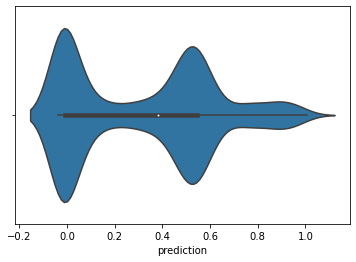

In [17]:
sns.violinplot(predictions[:3936])

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='prediction'>

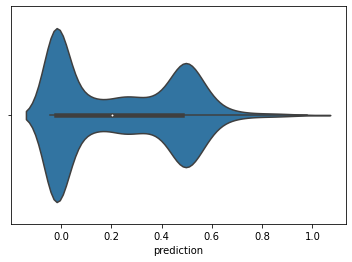

In [18]:
sns.violinplot(predictions[3936:7872])

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='prediction'>

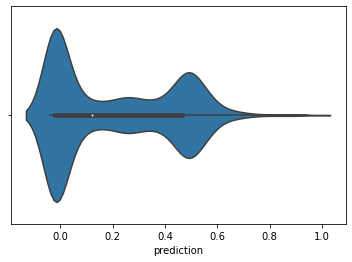

In [19]:
sns.violinplot(predictions[7872:11808])

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='prediction'>

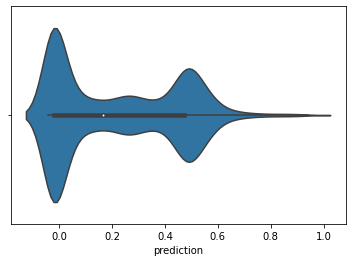

In [20]:
sns.violinplot(predictions[11808:])

In [21]:
# find confusion matrix of positive and permuted negative data
preds_subset_confusion_matrix = sklearn.metrics.confusion_matrix(targets[:7872], preds_round[:7872])

true_neg_subset = preds_subset_confusion_matrix[0,0]
false_pos_subset = preds_subset_confusion_matrix[0,1]
false_neg_subset = preds_subset_confusion_matrix[1,0]
true_pos_subset = preds_subset_confusion_matrix[1,1]

true_neg_subset_rate = true_neg_subset / (true_neg_subset + false_pos_subset)
false_pos_subset_rate = false_pos_subset / (true_neg_subset + false_pos_subset)
false_neg_subset_rate = false_neg_subset / (true_pos_subset + false_neg_subset)
true_pos_subset_rate = true_pos_subset / (true_pos_subset + false_neg_subset)

In [22]:
print('True Negative Subset Rate: {}'.format(true_neg_subset_rate))
print('False Positive Subset Rate: {}'.format(false_pos_subset_rate))
print('False Negative Subset Rate: {}'.format(false_neg_subset_rate))
print('True Positive Subset Rate: {}'.format(true_pos_subset_rate))

True Negative Subset Rate: 0.8261000602772754
False Positive Subset Rate: 0.17389993972272452
False Negative Subset Rate: 0.6326306543697848
True Positive Subset Rate: 0.36736934563021517


### Compare validation classification accuracy to frequency of appearance in training data

In [23]:
# create dictionaries that map all unique CDR3 and antigen sequences
# to their targets and predictions of classification
cdr3_valid_preds = {}
cdr3_valid_targets = {}
antigen_valid_preds = {}
antigen_valid_targets = {}

for inp, tar, pred in zip(inputs, targets, preds_round):
# for inp, tar, pred in zip(inputs[:7872], targets[:7872], preds_round[:7872]):
    sep = np.where(inp == 3)[0]
    cdr3_sep = sep[0]      # where does CDR3 seq end and antigen begin?
    antigen_sep = sep[1]   # where does antigen seq end and padding begin?
    cdr3 = tuple(inp[:cdr3_sep+1])
    antigen = tuple(np.concatenate(([2], inp[cdr3_sep+1:antigen_sep+1])))   # truncate to only antigen
    if cdr3 not in cdr3_valid_preds.keys():
        cdr3_valid_preds[cdr3] = [pred]
        cdr3_valid_targets[cdr3] = [tar]
    else:
        cdr3_valid_preds[cdr3] += [pred]
        cdr3_valid_targets[cdr3] += [tar]
        
    if antigen not in antigen_valid_preds.keys():
        antigen_valid_preds[antigen] = [pred]
        antigen_valid_targets[antigen] = [tar]
    else:
        antigen_valid_preds[antigen] += [pred]
        antigen_valid_targets[antigen] += [tar]

In [24]:
# find accuracy of model performance on each CDR3 sequence
cdr3_valid_accuracy = {}
for cdr3 in cdr3_valid_preds.keys():
    pred = cdr3_valid_preds[cdr3]
    tar = cdr3_valid_targets[cdr3]
    matches = np.sum(~np.logical_xor(pred, tar))
    accuracy = matches / float(len(pred))
    cdr3_valid_accuracy[cdr3] = accuracy

antigen_valid_accuracy = {}
for antigen in antigen_valid_preds.keys():
    pred = antigen_valid_preds[antigen]
    tar = antigen_valid_targets[antigen]
    matches = np.sum(~np.logical_xor(pred, tar))
    accuracy = matches / float(len(pred))
    antigen_valid_accuracy[antigen] = accuracy

In [25]:
cdr3_valid_accuracy_list = []
cdr3_valid_freq_in_train = []
for cdr3 in cdr3_valid_accuracy.keys():
    cdr3_valid_accuracy_list += [cdr3_valid_accuracy[cdr3]]
    if cdr3 not in cdr3_train_counts.keys():
        cdr3_valid_freq_in_train += [0]
    else:
        cdr3_valid_freq_in_train += [cdr3_train_counts[cdr3]]
        
antigen_valid_accuracy_list = []
antigen_valid_freq_in_train = []
for antigen in antigen_valid_accuracy.keys():
    antigen_valid_accuracy_list += [antigen_valid_accuracy[antigen]]
    if antigen not in antigen_train_counts.keys():
        antigen_valid_freq_in_train += [0]
    else:
        antigen_valid_freq_in_train += [antigen_train_counts[antigen]]
        
cdr3_valid_accuracy_list = np.array(cdr3_valid_accuracy_list)
cdr3_valid_freq_in_train = np.array(cdr3_valid_freq_in_train)
antigen_valid_accuracy_list = np.array(antigen_valid_accuracy_list)
antigen_valid_freq_in_train = np.array(antigen_valid_freq_in_train)

In [26]:
set(antigen_train_counts.keys()).intersection(set(antigen_valid_accuracy.keys()))

{(2.0, 5.0, 19.0, 5.0, 21.0, 15.0, 9.0, 21.0, 21.0, 12.0, 22.0, 5.0, 3.0),
 (2.0, 5.0, 23.0, 8.0, 5.0, 15.0, 16.0, 23.0, 11.0, 28.0, 3.0),
 (2.0, 5.0, 25.0, 10.0, 8.0, 21.0, 14.0, 22.0, 8.0, 5.0, 14.0, 3.0),
 (2.0, 7.0, 13.0, 17.0, 11.0, 25.0, 7.0, 26.0, 23.0, 25.0, 3.0),
 (2.0,
  7.0,
  19.0,
  22.0,
  20.0,
  9.0,
  19.0,
  16.0,
  22.0,
  13.0,
  28.0,
  25.0,
  28.0,
  3.0),
 (2.0, 7.0, 23.0, 19.0, 28.0, 8.0, 13.0, 17.0, 20.0, 16.0, 3.0),
 (2.0, 7.0, 25.0, 17.0, 11.0, 22.0, 7.0, 10.0, 23.0, 25.0, 3.0),
 (2.0,
  8.0,
  5.0,
  23.0,
  28.0,
  20.0,
  21.0,
  23.0,
  21.0,
  5.0,
  15.0,
  25.0,
  21.0,
  3.0),
 (2.0, 8.0, 9.0, 9.0, 8.0, 5.0, 13.0, 5.0, 5.0, 28.0, 3.0),
 (2.0,
  8.0,
  19.0,
  10.0,
  21.0,
  15.0,
  15.0,
  20.0,
  17.0,
  22.0,
  20.0,
  25.0,
  10.0,
  22.0,
  3.0),
 (2.0, 9.0, 9.0, 17.0, 15.0, 15.0, 8.0, 10.0, 25.0, 21.0, 10.0, 3.0),
 (2.0, 9.0, 13.0, 28.0, 14.0, 21.0, 26.0, 13.0, 13.0, 3.0),
 (2.0, 9.0, 15.0, 5.0, 11.0, 13.0, 11.0, 13.0, 15.0, 23.0, 25.0, 3.0),
 

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

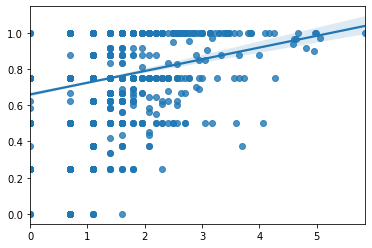

In [27]:
# prediction accuracy for each CDR3 sequence as a function of how many
# times it was seen in the training data
sns.regplot(np.log(cdr3_valid_freq_in_train+1), cdr3_valid_accuracy_list)

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

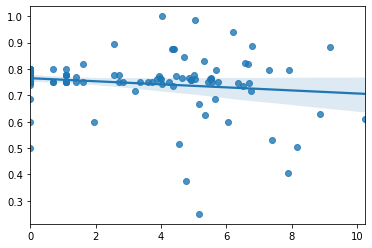

In [28]:
# prediction accuracy for each antigen sequence as a function of how many
# times it was seen in the training data
sns.regplot(np.log(antigen_valid_freq_in_train+1), antigen_valid_accuracy_list)

### Check performance across TRA vs TRB chains

In [29]:
# relevant data files
tra_cdr3_train_file = data_dir + '/TRA_cdr3.fasta'
trb_cdr3_train_file = data_dir + '/TRB_cdr3.fasta'

# load relevant data
tra_cdr3_seq_unprocessed = FastaDataset(tra_cdr3_train_file, in_memory=True)
trb_cdr3_seq_unprocessed = FastaDataset(trb_cdr3_train_file, in_memory=True)

In [30]:
# convert sequence strings into list of ints
tra_cdr3_seq = [tuple(tokenizer.encode(x['primary'])) for x in tra_cdr3_seq_unprocessed]
trb_cdr3_seq = [tuple(tokenizer.encode(x['primary'])) for x in trb_cdr3_seq_unprocessed]

In [31]:
tra_cdr3_accuracy = []
for cdr3 in tra_cdr3_seq:
    if cdr3 in cdr3_valid_accuracy.keys():
        tra_cdr3_accuracy += [cdr3_valid_accuracy[cdr3]]
        
trb_cdr3_accuracy = []
for cdr3 in trb_cdr3_seq:
    if cdr3 in cdr3_valid_accuracy.keys():
        trb_cdr3_accuracy += [cdr3_valid_accuracy[cdr3]]

In [32]:
# interesting sidenote: apparently hash of ints are same as hash of floats
print(tra_cdr3_seq[0])
print(list(cdr3_valid_accuracy.keys())[2])
print(hash(2.0))
print(hash(2))

(2, 7, 15, 25, 11, 8, 14, 11, 8, 8, 14, 13, 13, 10, 3)
(2.0, 7.0, 5.0, 26.0, 22.0, 15.0, 11.0, 11.0, 21.0, 11.0, 9.0, 20.0, 28.0, 10.0, 3.0)
2
2


DescribeResult(nobs=1143, minmax=(0.0, 1.0), mean=0.769130681581469, variance=0.046544207508484606, skewness=-0.6493335193254149, kurtosis=-0.15966706589940927)


/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


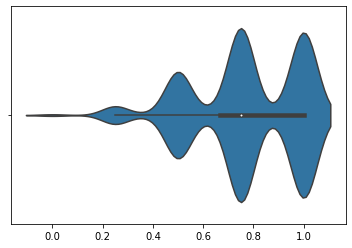

In [33]:
sns.violinplot(tra_cdr3_accuracy)
print(scipy.stats.describe(tra_cdr3_accuracy))

DescribeResult(nobs=2688, minmax=(0.0, 1.0), mean=0.6943218606583562, variance=0.04721610253570919, skewness=-0.507767370006405, kurtosis=-0.030173934220280696)


/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


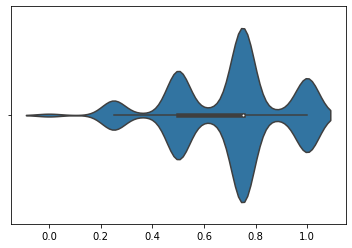

In [34]:
sns.violinplot(trb_cdr3_accuracy)
print(scipy.stats.describe(trb_cdr3_accuracy))

### Compare performance across different species

In [35]:
# relevant data files
human_cdr3_train_file = data_dir + '/HomoSapiens_cdr3.fasta'
mouse_cdr3_train_file = data_dir + '/MusMusculus_cdr3.fasta'
macaque_cdr3_train_file = data_dir + '/MacacaMulatta_cdr3.fasta'

human_antigen_train_file = data_dir + '/HomoSapiens_antigen.fasta'
mouse_antigen_train_file = data_dir + '/MusMusculus_antigen.fasta'
macaque_antigen_train_file = data_dir + '/MacacaMulatta_antigen.fasta'

# load relevant data
human_cdr3_seq_unprocessed = FastaDataset(human_cdr3_train_file, in_memory=True)
mouse_cdr3_seq_unprocessed = FastaDataset(mouse_cdr3_train_file, in_memory=True)
macaque_cdr3_seq_unprocessed = FastaDataset(macaque_cdr3_train_file, in_memory=True)

human_antigen_seq_unprocessed = FastaDataset(human_antigen_train_file, in_memory=True)
mouse_antigen_seq_unprocessed = FastaDataset(mouse_antigen_train_file, in_memory=True)
macaque_antigen_seq_unprocessed = FastaDataset(macaque_antigen_train_file, in_memory=True)

In [36]:
# convert sequence strings into list of ints
human_cdr3_seq = [tuple(tokenizer.encode(x['primary'])) for x in human_cdr3_seq_unprocessed]
mouse_cdr3_seq = [tuple(tokenizer.encode(x['primary'])) for x in mouse_cdr3_seq_unprocessed]
macaque_cdr3_seq = [tuple(tokenizer.encode(x['primary'])) for x in macaque_cdr3_seq_unprocessed]

human_antigen_seq = [tuple(tokenizer.encode(x['primary'])) for x in human_antigen_seq_unprocessed]
mouse_antigen_seq = [tuple(tokenizer.encode(x['primary'])) for x in mouse_antigen_seq_unprocessed]
macaque_antigen_seq = [tuple(tokenizer.encode(x['primary'])) for x in macaque_antigen_seq_unprocessed]

In [37]:
human_cdr3_accuracy = []
human_cdr3_accuracy_dict = {}
for cdr3 in human_cdr3_seq:
    if cdr3 in cdr3_valid_accuracy.keys():
        human_cdr3_accuracy += [cdr3_valid_accuracy[cdr3]]
        human_cdr3_accuracy_dict[cdr3] = cdr3_valid_accuracy[cdr3]
        
mouse_cdr3_accuracy = []
mouse_cdr3_accuracy_dict = {}
for cdr3 in mouse_cdr3_seq:
    if cdr3 in cdr3_valid_accuracy.keys():
        mouse_cdr3_accuracy += [cdr3_valid_accuracy[cdr3]]
        mouse_cdr3_accuracy_dict[cdr3] = cdr3_valid_accuracy[cdr3]
        
macaque_cdr3_accuracy = []
macaque_cdr3_accuracy_dict = {}
for cdr3 in macaque_cdr3_seq:
    if cdr3 in cdr3_valid_accuracy.keys():
        macaque_cdr3_accuracy += [cdr3_valid_accuracy[cdr3]]
        macaque_cdr3_accuracy_dict[cdr3] = cdr3_valid_accuracy[cdr3]
        
human_antigen_accuracy = []
human_antigen_accuracy_dict = {}
for antigen in human_antigen_seq:
    if antigen in antigen_valid_accuracy.keys():
        human_antigen_accuracy += [antigen_valid_accuracy[antigen]]
        human_antigen_accuracy_dict[antigen] = antigen_valid_accuracy[antigen]
        
mouse_antigen_accuracy = []
mouse_antigen_accuracy_dict = {}
for antigen in mouse_antigen_seq:
    if antigen in antigen_valid_accuracy.keys():
        mouse_antigen_accuracy += [antigen_valid_accuracy[antigen]]
        mouse_antigen_accuracy_dict[antigen] = antigen_valid_accuracy[antigen]
        
macaque_antigen_accuracy = []
macaque_antigen_accuracy_dict = {}
for antigen in macaque_antigen_seq:
    if antigen in antigen_valid_accuracy.keys():
        macaque_antigen_accuracy += [antigen_valid_accuracy[antigen]]
        macaque_antigen_accuracy_dict[antigen] = antigen_valid_accuracy[antigen]

In [38]:
macaque_antigen_accuracy_dict

{(2, 7, 23, 19, 28, 8, 13, 17, 20, 16, 3): 0.7465794170136824,
 (2, 23, 23, 19, 9, 22, 5, 17, 15, 3): 0.7150928167877321,
 (2, 22, 23, 19, 9, 22, 5, 17, 15, 3): 0.75}

DescribeResult(nobs=2741, minmax=(0.0, 1.0), mean=0.7313377330136724, variance=0.04772283443270428, skewness=-0.5704194276578093, kurtosis=-0.08578509931910716)


/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


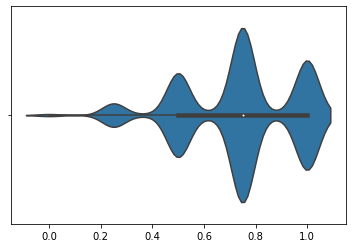

In [39]:
sns.violinplot(human_cdr3_accuracy)
print(scipy.stats.describe(human_cdr3_accuracy))

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


DescribeResult(nobs=332, minmax=(0.0, 1.0), mean=0.660608505450373, variance=0.048037292633318684, skewness=-0.3222761618599201, kurtosis=-0.1791827245858002)


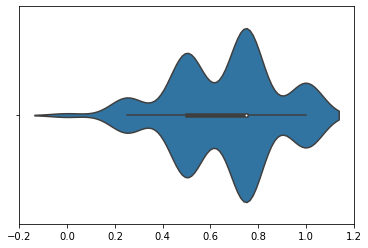

In [40]:
sns.violinplot(mouse_cdr3_accuracy)
print(scipy.stats.describe(mouse_cdr3_accuracy))

DescribeResult(nobs=766, minmax=(0.0, 1.0), mean=0.6886877029990607, variance=0.04689721440100438, skewness=-0.5161097193007448, kurtosis=0.014886780302085345)


/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


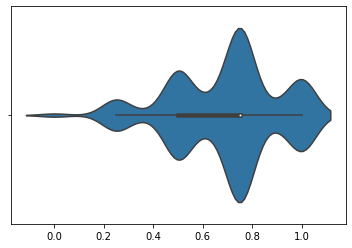

In [41]:
sns.violinplot(macaque_cdr3_accuracy)
print(scipy.stats.describe(macaque_cdr3_accuracy))

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


DescribeResult(nobs=114, minmax=(0.25, 1.0), mean=0.7450046931091512, variance=0.00992902592712013, skewness=-2.0836950205472244, kurtosis=7.4153557912987615)


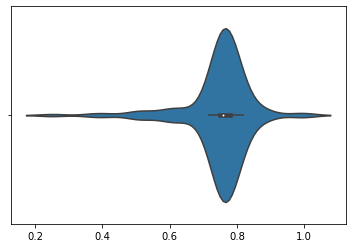

In [42]:
sns.violinplot(human_antigen_accuracy)
print(scipy.stats.describe(human_antigen_accuracy))

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


DescribeResult(nobs=12, minmax=(0.7384615384615385, 0.9384615384615385), mean=0.7984348969685932, variance=0.004934251153191316, skewness=0.9886534958131274, kurtosis=-0.6608571821454299)


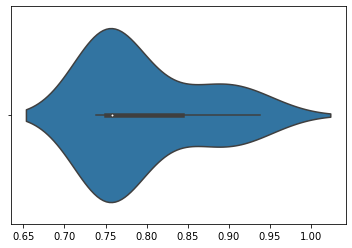

In [43]:
sns.violinplot(mouse_antigen_accuracy)
print(scipy.stats.describe(mouse_antigen_accuracy))

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


DescribeResult(nobs=3, minmax=(0.7150928167877321, 0.75), mean=0.7372240779338047, variance=0.00037026963692832313, skewness=-0.6820523158929412, kurtosis=-1.5000000000000127)


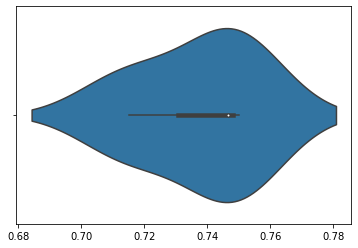

In [44]:
sns.violinplot(macaque_antigen_accuracy)
print(scipy.stats.describe(macaque_antigen_accuracy))

In [45]:
# what is distribution of how often CDR3 and antigen sequences are seen
# in different species?
human_cdr3_train_unique_freq = []         # number of sequences with each copy #
human_cdr3_train_weighted_freq = []
for cdr3 in human_cdr3_seq:
    if cdr3 in cdr3_train_counts.keys():
        count = cdr3_train_counts[cdr3]
        human_cdr3_train_unique_freq += [count]
        human_cdr3_train_weighted_freq += count*[count]
    
human_antigen_train_unique_freq = []         # number of sequences with each copy #
human_antigen_train_weighted_freq = []
for antigen in human_antigen_seq:
    if antigen in antigen_train_counts.keys():
        count = antigen_train_counts[antigen]
        human_antigen_train_unique_freq += [count]
        human_antigen_train_weighted_freq += count*[count]
        
mouse_cdr3_train_unique_freq = []         # number of sequences with each copy #
mouse_cdr3_train_weighted_freq = []
for cdr3 in mouse_cdr3_seq:
    if cdr3 in cdr3_train_counts.keys():
        count = cdr3_train_counts[cdr3]
        mouse_cdr3_train_unique_freq += [count]
        mouse_cdr3_train_weighted_freq += count*[count]
    
mouse_antigen_train_unique_freq = []         # number of sequences with each copy #
mouse_antigen_train_weighted_freq = []
for antigen in mouse_antigen_seq:
    if antigen in antigen_train_counts.keys():
        count = antigen_train_counts[antigen]
        mouse_antigen_train_unique_freq += [count]
        mouse_antigen_train_weighted_freq += count*[count]

macaque_cdr3_train_unique_freq = []         # number of sequences with each copy #
macaque_cdr3_train_weighted_freq = []
for cdr3 in macaque_cdr3_seq:
    if cdr3 in cdr3_train_counts.keys():
        count = cdr3_train_counts[cdr3]
        macaque_cdr3_train_unique_freq += [count]
        macaque_cdr3_train_weighted_freq += count*[count]
    
macaque_antigen_train_unique_freq = []         # number of sequences with each copy #
macaque_antigen_train_weighted_freq = []
for antigen in macaque_antigen_seq:
    if antigen in antigen_train_counts.keys():
        count = antigen_train_counts[antigen]
        macaque_antigen_train_unique_freq += [count]
        macaque_antigen_train_weighted_freq += count*[count]


In [46]:
pd.value_counts(human_cdr3_train_unique_freq).to_frame().sort_index().transpose()

,1,2,3,4,5,6,7,8,9,10,...,99,103,106,123,140,144,145,154,155,344
0,44481,4455,1048,449,225,106,78,51,49,30,...,1,1,1,1,1,1,1,1,1,1


In [47]:
pd.value_counts(mouse_cdr3_train_unique_freq).to_frame().sort_index().transpose()

,1,2,3,4,5,6,7,8,9,10,12,14,18,19,22,57,70
0,1244,147,40,13,20,10,7,6,4,2,3,1,1,1,1,1,1


In [48]:
pd.value_counts(macaque_cdr3_train_unique_freq).to_frame().sort_index().transpose()

,1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,21,23
0,781,293,42,42,15,2,3,3,2,2,1,1,1,1,1,1,1,1,1


In [49]:
pd.value_counts(human_antigen_train_unique_freq).to_frame().sort_index()[0:10]

,0
1,5
2,37
3,2
4,10
5,1
6,3
7,2
8,2
9,1
10,2


In [50]:
pd.value_counts(mouse_antigen_train_unique_freq).to_frame().sort_index()

,0
2,4
3,1
4,1
10,1
12,1
13,1
18,1
61,1
64,1
137,1


In [51]:
pd.value_counts(macaque_antigen_train_unique_freq).to_frame().sort_index()

,0
309,1
814,1
859,1


<AxesSubplot:ylabel='Density'>

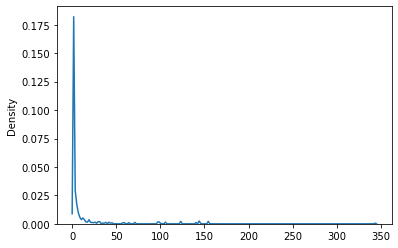

In [52]:
sns.kdeplot(human_cdr3_train_weighted_freq, bw_adjust=0.1)

<AxesSubplot:ylabel='Density'>

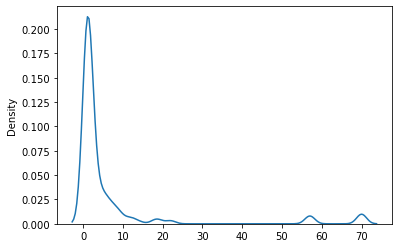

In [53]:
sns.kdeplot(mouse_cdr3_train_weighted_freq, bw_adjust=0.4)

<AxesSubplot:ylabel='Density'>

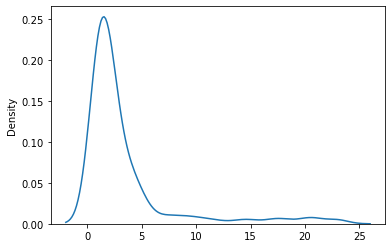

In [54]:
sns.kdeplot(macaque_cdr3_train_weighted_freq, bw_adjust=1)

<AxesSubplot:ylabel='Density'>

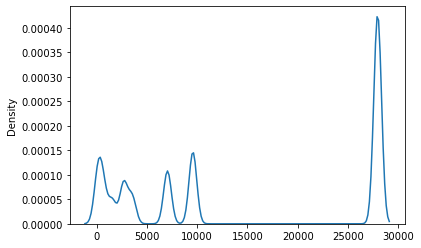

In [55]:
sns.kdeplot(human_antigen_train_weighted_freq, bw_adjust=0.3)

<AxesSubplot:ylabel='Density'>

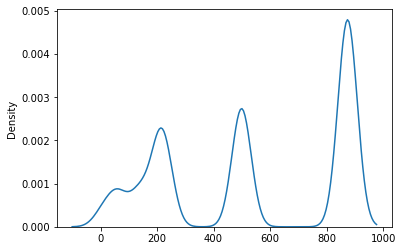

In [56]:
sns.kdeplot(mouse_antigen_train_weighted_freq, bw_adjust=.5)

<AxesSubplot:ylabel='Density'>

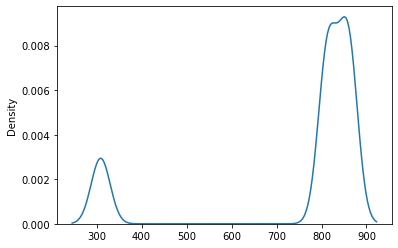

In [57]:
sns.kdeplot(macaque_antigen_train_weighted_freq, bw_adjust=.5)

In [58]:
# does mouse classification show significant relationship between frequency
# of antigen in training data and model performance?
mouse_cdr3_valid_accuracy_list = []
mouse_cdr3_valid_freq_in_train = []
for cdr3 in mouse_cdr3_accuracy_dict.keys():
    mouse_cdr3_valid_accuracy_list += [mouse_cdr3_accuracy_dict[cdr3]]
    if cdr3 not in cdr3_train_counts.keys():
        mouse_cdr3_valid_freq_in_train += [0]
    else:
        mouse_cdr3_valid_freq_in_train += [cdr3_train_counts[cdr3]]
        
mouse_antigen_valid_accuracy_list = []
mouse_antigen_valid_freq_in_train = []
for antigen in mouse_antigen_accuracy_dict.keys():
    mouse_antigen_valid_accuracy_list += [mouse_antigen_accuracy_dict[antigen]]
    if antigen not in antigen_train_counts.keys():
        mouse_antigen_valid_freq_in_train += [0]
    else:
        mouse_antigen_valid_freq_in_train += [antigen_train_counts[antigen]]
        
mouse_cdr3_valid_accuracy_list = np.array(mouse_cdr3_valid_accuracy_list)
mouse_cdr3_valid_freq_in_train = np.array(mouse_cdr3_valid_freq_in_train)
mouse_antigen_valid_accuracy_list = np.array(mouse_antigen_valid_accuracy_list)
mouse_antigen_valid_freq_in_train = np.array(mouse_antigen_valid_freq_in_train)

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

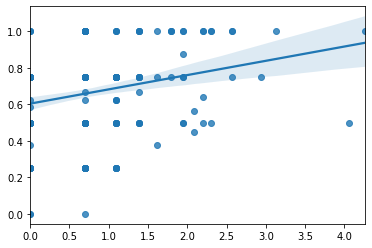

In [59]:
sns.regplot(np.log(mouse_cdr3_valid_freq_in_train+1), mouse_cdr3_valid_accuracy_list)

/group/ag_cmb/scratch/jqin/miniconda3/envs/tape/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

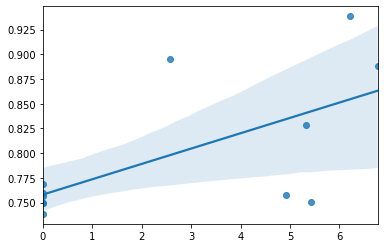

In [60]:
sns.regplot(np.log(mouse_antigen_valid_freq_in_train+1), mouse_antigen_valid_accuracy_list)